In [1]:
### Magic functinos
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
%matplotlib inline

In [2]:
### imports
import warnings
warnings.simplefilter('ignore')
import itertools
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from mliv.dgps import get_data, get_tau_fn, fn_dict
from mliv.neuralnet.utilities import mean_ci
from mliv.neuralnet import AGMMEarlyStop as AGMM
from mliv.neuralnet.moments import avg_small_diff
from sklearn.ensemble import RandomForestRegressor

## $\ell_2$-Regularized AGMM with Neural Net Test Function

We solve the problem:
\begin{equation}
\min_{\theta} \max_{w} \frac{1}{n} \sum_i (y_i - h_{\theta}(x_i)) f_w(z_i) - f_w(z_i)^2
\end{equation}
where $h_{\theta}$ and $f_w$ are two neural nets.

In [3]:
def exp(it, n, n_z, n_t, iv_strength, fname, dgp_num):
    np.random.seed(it)
    
    #####
    # Neural network parameters
    ####
    p = 0.1 # dropout prob of dropout layers throughout notebook
    n_hidden = 100 # width of hidden layers throughout notebook

    learner = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                            #nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                            nn.Dropout(p=p), nn.Linear(n_hidden, 1))

    # For any method that uses an unstructured adversary test function f(z)
    adversary_fn = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                                 #nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                                 nn.Dropout(p=p), nn.Linear(n_hidden, 1))

    learner_lr = 1e-4
    adversary_lr = 1e-4
    learner_l2 = 1e-3
    adversary_l2 = 1e-3
    n_epochs = 200
    bs = 100
    burn_in = 100
    device = None
    
    ######
    # Train test split
    ######
    Z, T, Y, true_fn = get_data(n, n_z, iv_strength, get_tau_fn(fn_dict[fname]), dgp_num)
    Z_train, Z_val, T_train, T_val, Y_train, Y_val = train_test_split(Z, T, Y, test_size=.5, shuffle=True)
    Z_train, T_train, Y_train = map(lambda x: torch.Tensor(x), (Z_train, T_train, Y_train))
    Z_val, T_val, Y_val = map(lambda x: torch.Tensor(x).to(device), (Z_val, T_val, Y_val))
    
    
    #####
    # Train IV function and "riesz" representer xi
    #####
    np.random.seed(12356)
    agmm = AGMM(learner, adversary_fn).fit(Z_train, T_train, Y_train, Z_val, T_val, Y_val,
                                           learner_lr=learner_lr, adversary_lr=adversary_lr,
                                           learner_l2=learner_l2, adversary_l2=adversary_l2,
                                           n_epochs=n_epochs, bs=bs, logger=None,
                                           model_dir=f'agmm_model_{it}', device=device)

    reisz = AGMM(learner, adversary_fn).fit(Z_train, T_train, Y_train, Z_val, T_val, Y_val,
                                            learner_lr=learner_lr, adversary_lr=adversary_lr,
                                            learner_l2=learner_l2, adversary_l2=adversary_l2,
                                            n_epochs=n_epochs, bs=bs, logger=None,
                                            model_dir=f'riesz_model_{it}', device=device,
                                            riesz=True, moment_fn=avg_small_diff)

    qfun = RandomForestRegressor(min_samples_leaf=20).fit(Z_train, reisz.predict(T_train))
    qfun_avg = RandomForestRegressor(min_samples_leaf=20).fit(Z_train,
                                                              reisz.predict(T_train, model='avg', burn_in=burn_in))
    
    #####
    # Average moment calculation
    #####
    direct = avg_small_diff(T_val, agmm.predict, device='cpu').flatten()
    residual = (Y_val - agmm.predict(T_val)).detach().numpy().flatten()
    qvalues = qfun.predict(Z_val).flatten()
    pseudo = direct + qvalues * residual
    dr = mean_ci(pseudo)
    ipw = mean_ci(qvalues * Y_val.detach().numpy().flatten())
    reg = mean_ci(direct)
    
    xivalues = reisz.predict(T_val).flatten()
    coef = np.mean(qvalues * residual) / np.mean(qvalues * xivalues)
    pseudo_tmle = direct + coef * avg_small_diff(T_val, reisz.predict, device='cpu').flatten()
    pseudo_tmle += qvalues * (residual - coef * xivalues)
    tmle = mean_ci(pseudo_tmle)
    
    direct_avg = avg_small_diff(T_val,
                                lambda x: agmm.predict(x, model='avg', burn_in=burn_in), device='cpu').flatten()
    residual_avg = (Y_val - agmm.predict(T_val, model='avg', burn_in=burn_in)).detach().numpy().flatten()
    qvalues_avg = qfun_avg.predict(Z_val).flatten()
    pseudo_avg = direct_avg + qvalues_avg * residual_avg
    dr_avg = mean_ci(pseudo_avg)
    ipw_avg = mean_ci(qvalues_avg * Y_val.detach().numpy().flatten())
    reg_avg = mean_ci(direct_avg)

    xivalues_avg = reisz.predict(T_val, model='avg', burn_in=burn_in).flatten()
    coef_avg = np.mean(qvalues_avg * residual_avg) / np.mean(qvalues_avg * xivalues_avg)
    pseudo_tmle_avg = (direct_avg 
                       + coef_avg * avg_small_diff(T_val, lambda x: reisz.predict(x, model='avg', burn_in=burn_in),
                                               device='cpu').flatten())
    pseudo_tmle_avg += qvalues_avg * (residual_avg - coef_avg * xivalues_avg)
    tmle_avg = mean_ci(pseudo_tmle_avg)

    return dr, tmle, ipw, reg, dr_avg, tmle_avg, ipw_avg, reg_avg

In [4]:
n = 2000
n_z = 1
n_t = 1
iv_strength = .7
fname = 'sigmoid'
dgp_num = 5

Z, T, Y, true_fn = get_data(1000000, n_z, iv_strength, get_tau_fn(fn_dict[fname]), dgp_num)
true = np.mean(avg_small_diff(T, true_fn, device='cpu'))
print(f'True: {true:.4f}')

True: 0.1906


In [5]:
exp(1, n, n_z, n_t, iv_strength, fname, dgp_num)

f(z_dev) collection prepared.
Epoch #0
Current moment approx: 0.13888467848300934
Epoch #1
Current moment approx: 0.13537761569023132
Epoch #2
Current moment approx: 0.1323298066854477
Epoch #3
Current moment approx: 0.12919430434703827
Epoch #4
Current moment approx: 0.12656164169311523
Epoch #5
Current moment approx: 0.12408392131328583
Epoch #6
Current moment approx: 0.12254101037979126
Epoch #7
Current moment approx: 0.12247496098279953
Epoch #8
Current moment approx: 0.12715351581573486
Epoch #9
Current moment approx: 0.1391497254371643
Epoch #10
Current moment approx: 0.15136218070983887
Epoch #11
Current moment approx: 0.16256661713123322
Epoch #12
Current moment approx: 0.17076368629932404
Epoch #13
Current moment approx: 0.1769772469997406
Epoch #14
Current moment approx: 0.1825568526983261
Epoch #15
Current moment approx: 0.18737180531024933
Epoch #16
Current moment approx: 0.18800903856754303
Epoch #17
Current moment approx: 0.18644657731056213
Epoch #18
Current moment appro

Current moment approx: 0.0036436195950955153
Epoch #154
Current moment approx: 0.004752160049974918
Epoch #155
Current moment approx: 0.0018360092071816325
Epoch #156
Current moment approx: 0.0018853754736483097
Epoch #157
Current moment approx: 0.001680496265180409
Epoch #158
Current moment approx: 0.004753662273287773
Epoch #159
Current moment approx: 0.008843247778713703
Epoch #160
Current moment approx: 0.010966955684125423
Epoch #161
Current moment approx: 0.008751844987273216
Epoch #162
Current moment approx: 0.007365087512880564
Epoch #163
Current moment approx: 0.0017447664868086576
Epoch #164
Current moment approx: 0.0017070297617465258
Epoch #165
Current moment approx: 0.0019737430848181248
Epoch #166
Current moment approx: 0.0015047875931486487
Epoch #167
Current moment approx: 0.0017066674772650003
Epoch #168
Current moment approx: 0.0017579050036147237
Epoch #169
Current moment approx: 0.006415653973817825
Epoch #170
Current moment approx: 0.005766290705651045
Epoch #171
C

Current moment approx: -0.1806718111038208
Epoch #108
Current moment approx: -0.1807306408882141
Epoch #109
Current moment approx: -0.18120069801807404
Epoch #110
Current moment approx: -0.1804230660200119
Epoch #111
Current moment approx: -0.17818200588226318
Epoch #112
Current moment approx: -0.17925290763378143
Epoch #113
Current moment approx: -0.18181252479553223
Epoch #114
Current moment approx: -0.18313397467136383
Epoch #115
Current moment approx: -0.18511958420276642
Epoch #116
Current moment approx: -0.18523621559143066
Epoch #117
Current moment approx: -0.18417426943778992
Epoch #118
Current moment approx: -0.187375009059906
Epoch #119
Current moment approx: -0.18802319467067719
Epoch #120
Current moment approx: -0.18815389275550842
Epoch #121
Current moment approx: -0.19048193097114563
Epoch #122
Current moment approx: -0.19048693776130676
Epoch #123
Current moment approx: -0.19232714176177979
Epoch #124
Current moment approx: -0.192342147231102
Epoch #125
Current moment ap

((0.19578627368855744, 0.1768041662873017, 0.2147683810898132),
 (0.19742993, 0.17845741445856989, 0.21640243594807684),
 (0.11341195552345505, 0.09054841115933546, 0.13627549988757465),
 (0.193521, 0.1885539375866928, 0.19848804840192413),
 (0.18893711203307975, 0.17204069850461942, 0.20583352556154008),
 (0.19759484, 0.18074376997547495, 0.2144459027330364),
 (0.10081147739539759, 0.08048076663653879, 0.12114218815425638),
 (0.17972498, 0.17528707076447567, 0.1841628820763294))

In [6]:
import joblib
from joblib import Parallel, delayed

n_z = 1
n_t = 1
fname = 'sigmoid'
dgp_num = 5

for n in [1000, 2000, 5000]:
    for iv_strength in [.5, .7, .9]:
        Z, T, Y, true_fn = get_data(1000000, n_z, iv_strength, get_tau_fn(fn_dict[fname]), dgp_num)
        true = np.mean(avg_small_diff(T, true_fn, device='cpu'))
        print(f'True: {true:.4f}')
        results = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, n_z, n_t, iv_strength, fname, dgp_num)
                                                 for it in range(100))
        joblib.dump((true, results), f'res_n_{n}_stregth_{iv_strength}.jbl')

True: 0.1884


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.4min finished


True: 0.1910


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.1min finished


True: 0.1787


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.2min finished


True: 0.1888


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.9min finished


True: 0.1909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.8min finished


True: 0.1782


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.8min finished


True: 0.1888


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 24.9min finished


True: 0.1910


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.0min finished


True: 0.1784


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 24.7min finished


In [7]:
def plot_results(n, iv_strength, dr, tmle, ipw, direct, true):
    plt.title(f'n={n}, strength={iv_strength}, true={true:.3f}\n'
              f'dr: Cov={np.mean((dr[:, 1] <= true) & (true <= dr[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((dr[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((dr[:, 0]-true)):.3f}\n'
              f'tmle: Cov={np.mean((tmle[:, 1] <= true) & (true <= tmle[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((tmle[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((tmle[:, 0]-true)):.3f}\n'
              f'ipw: Cov={np.mean((ipw[:, 1] <= true) & (true <= ipw[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((ipw[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((ipw[:, 0]-true)):.3f}\n'
              f'direct: Cov={np.mean((direct[:, 1] <= true) & (true <= direct[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((direct[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((direct[:, 0]-true)):.3f}\n')
    plt.hist(dr[:, 0], label='dr')
    plt.hist(tmle[:, 0], label='tmle', alpha=.4)
    plt.hist(ipw[:, 0], label='ipw', alpha=.4)
    plt.hist(direct[:, 0], label='direct', alpha=.4)
    plt.legend()

### Results from early stopping models

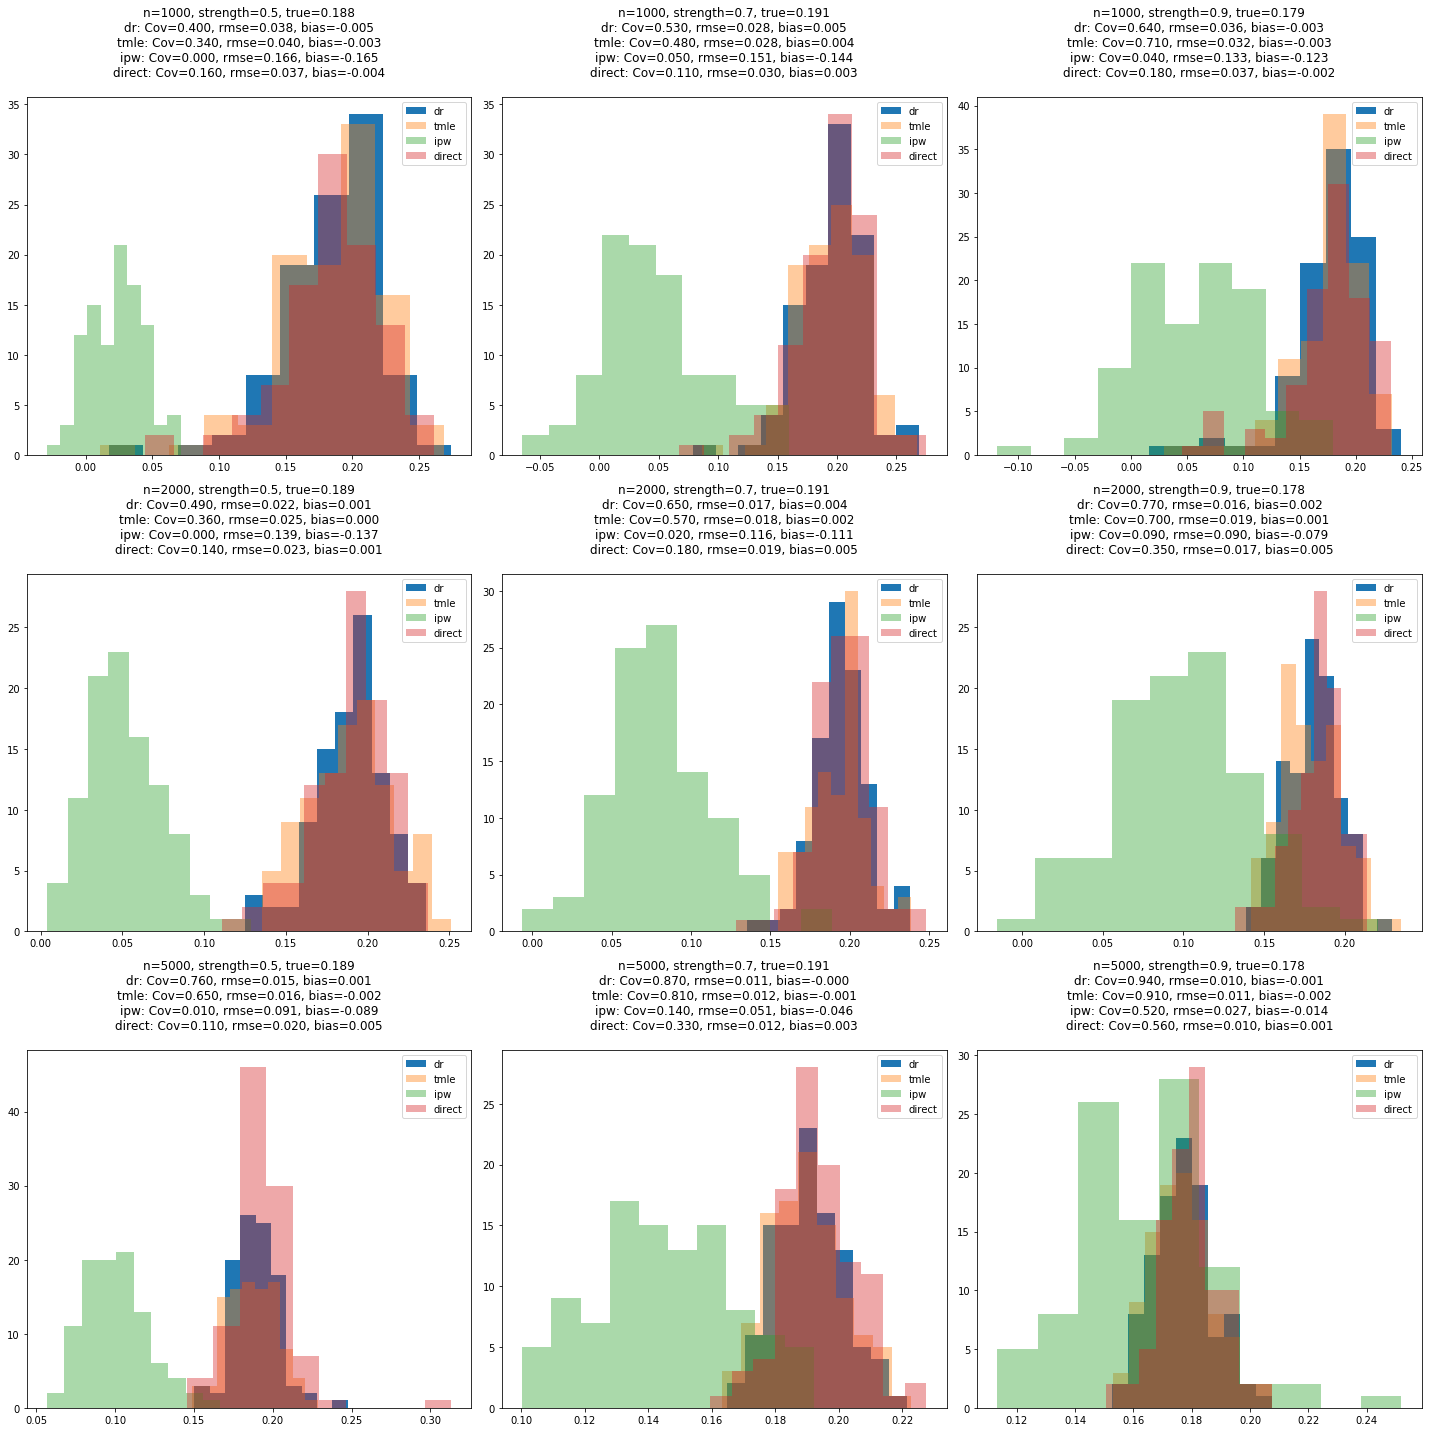

In [8]:
plt.figure(figsize=(20, 20))
it = 1
for n in [1000, 2000, 5000]:
    for iv_strength in [.5, .7, .9]:
        plt.subplot(3, 3, it)
        true, results = joblib.load(f'res_n_{n}_stregth_{iv_strength}.jbl')
        dr = np.array([r[0] for r in results])
        tmle = np.array([r[1] for r in results])
        ipw = np.array([r[2] for r in results])
        direct = np.array([r[3] for r in results])
        plot_results(n, iv_strength, dr, tmle, ipw, direct, true)
        it += 1
plt.tight_layout()
plt.show()

### Results from avg models

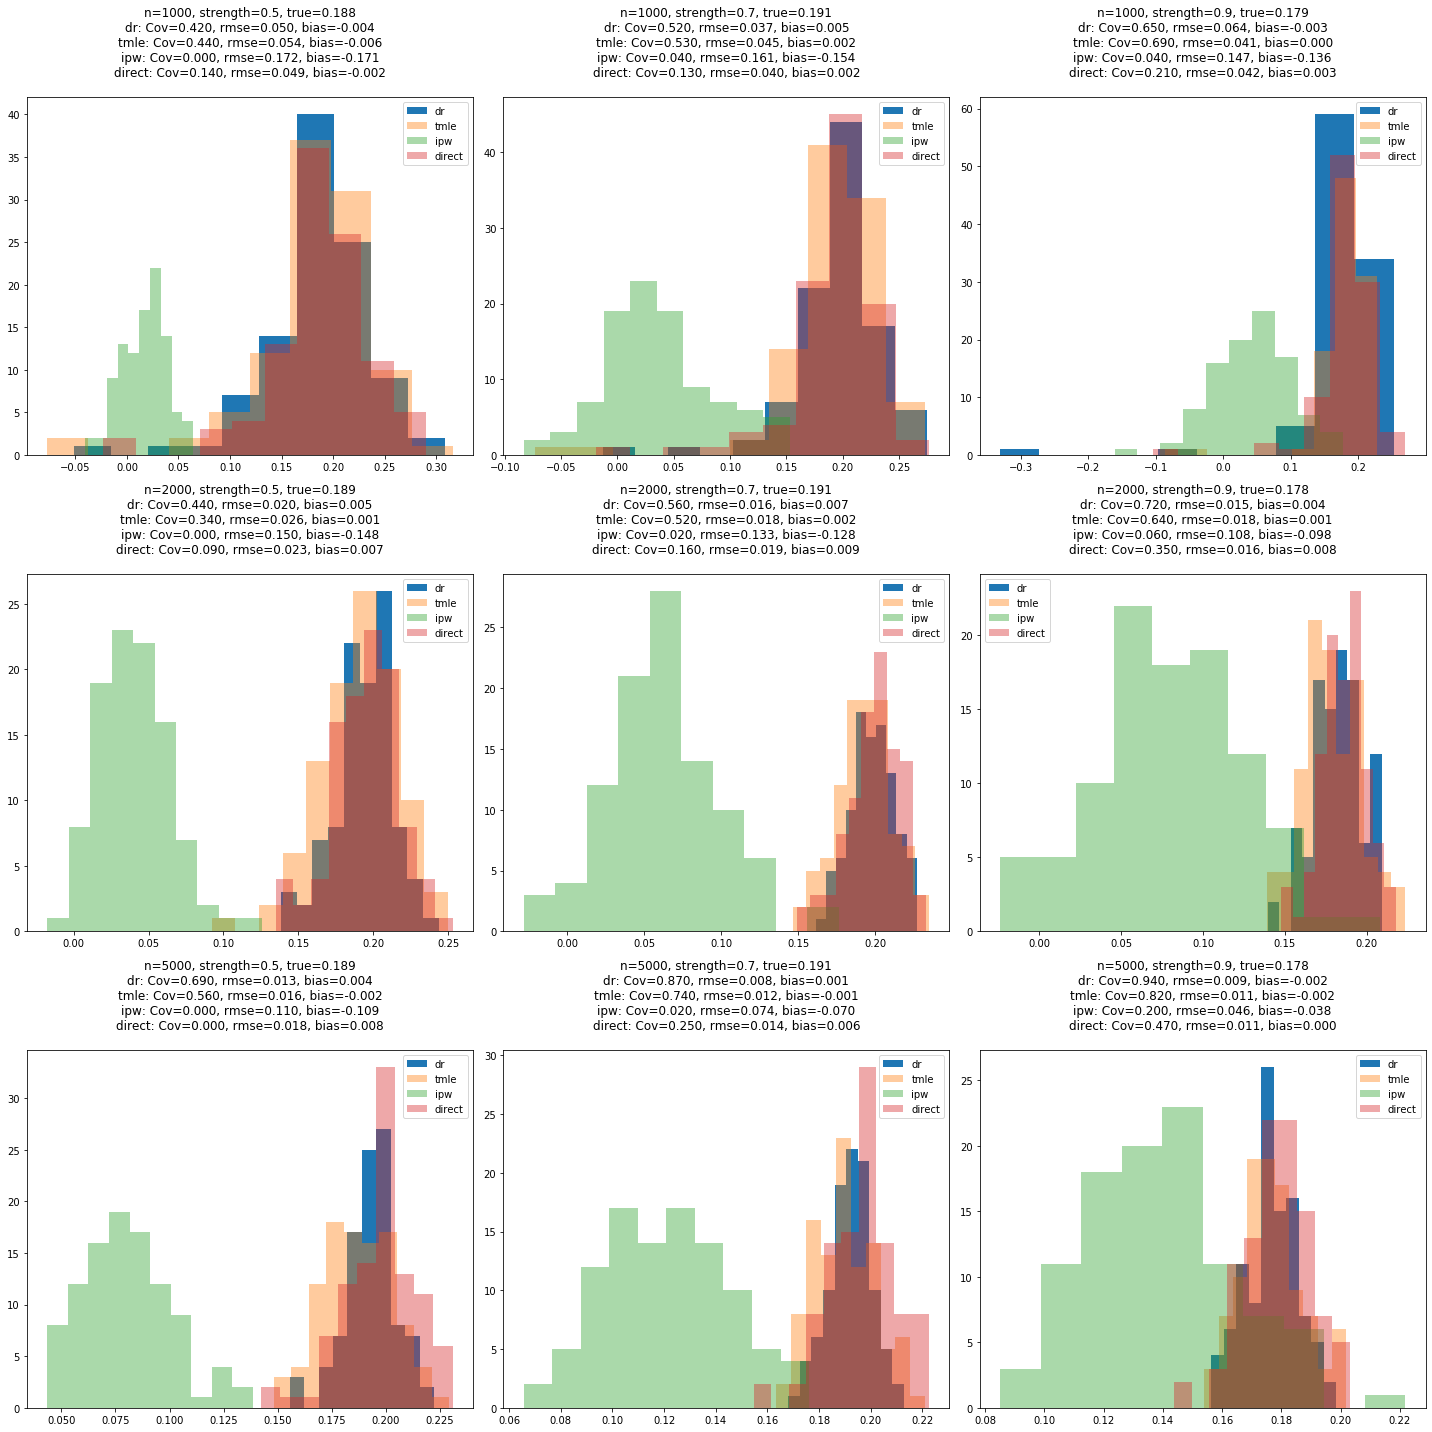

In [9]:
plt.figure(figsize=(20, 20))
it = 1
for n in [1000, 2000, 5000]:
    for iv_strength in [.5, .7, .9]:
        plt.subplot(3, 3, it)
        true, results = joblib.load(f'res_n_{n}_stregth_{iv_strength}.jbl')
        dr = np.array([r[4] for r in results])
        tmle = np.array([r[5] for r in results])
        ipw = np.array([r[6] for r in results])
        direct = np.array([r[7] for r in results])
        plot_results(n, iv_strength, dr, tmle, ipw, direct, true)
        it += 1

plt.tight_layout()
plt.show()